## hk total MSW generated per capita & hk total disposal per capita & hk total recycling volume per capita & hk total recycling rate

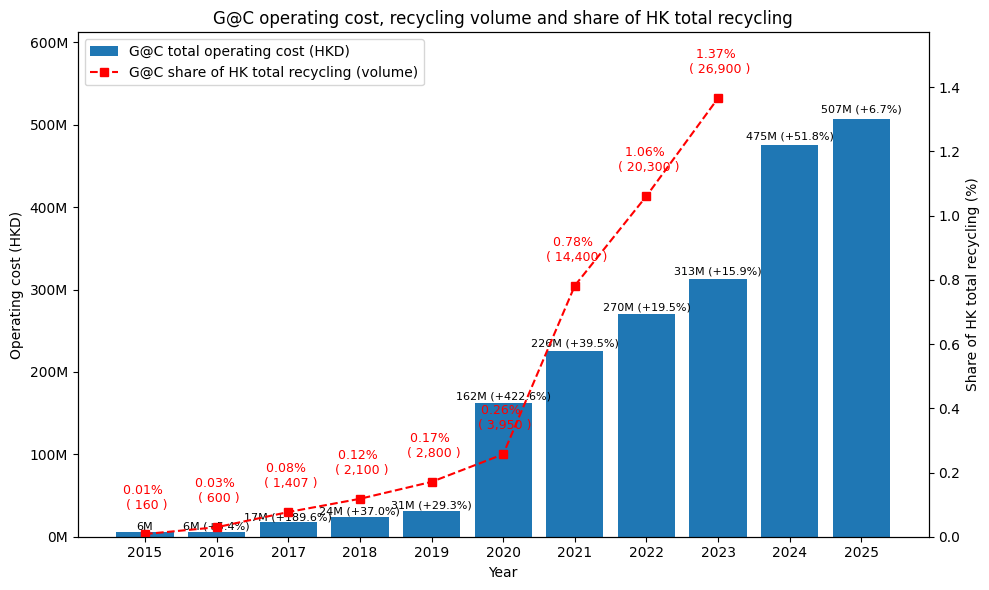

In [2]:
# ==== Install required packages (run these in a terminal, not inside Python) ====
# pip install pandas matplotlib openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math

# -------------------------------------------------------
# 1. Load data from the Excel file
# -------------------------------------------------------
excel_path = "../General Stats_G@C_clean.xlsx"

# Sheet with HK MSW & G@C recycling volume / share
hk = pd.read_excel(
    excel_path,
    sheet_name="HK MSW Volume and Recycling Rat"
)

# Sheet with G@C total operating cost
gc = pd.read_excel(
    excel_path,
    sheet_name="G@C Recyclables Collection Volu"
)

# -------------------------------------------------------
# 2. Prepare and merge the relevant data
# -------------------------------------------------------

# Keep only the columns we need from the HK sheet
hk_sub = hk[[
    "Year",
    "G@C recyclables collection volume (tonnes)",
    "G@C share of HK total MSW recycling"
]].dropna(subset=["Year"]).copy()

# Convert year to integer (e.g. 2015.0 -> 2015)
hk_sub["Year_int"] = hk_sub["Year"].astype(int)

# Extract the starting year (first 4 digits) from the G@C fiscal year text
# e.g. "2015-16" -> 2015, "2025-26 (budget)" -> 2025
gc["Year_num"] = gc["Year"].astype(str).str[:4].astype(int)

# Keep only total operating cost + the numeric year
gc_sub = gc[["Year_num", "G@C total operating cost"]].copy()

# Merge: calendar year from HK sheet with operating cost from G@C sheet
merged = (
    hk_sub.merge(
        gc_sub,
        left_on="Year_int",
        right_on="Year_num",
        how="inner"
    )
    .sort_values("Year_int")
)

# Convert share to percentage (for the right Y-axis)
merged["share_percent"] = merged["G@C share of HK total MSW recycling"] * 100

# Year-on-year percentage change of operating cost
merged["cost_pct_change"] = merged["G@C total operating cost"].pct_change() * 100

# -------------------------------------------------------
# 3. Plot: bar + red line
# -------------------------------------------------------

fig, ax1 = plt.subplots(figsize=(10, 6))

x = merged["Year_int"]

# Bar on left Y-axis: operating cost (full value)
bar_cost = ax1.bar(
    x,
    merged["G@C total operating cost"],
    label="G@C total operating cost (HKD)",
)

ax1.set_xlabel("Year")
ax1.set_ylabel("Operating cost (HKD)")

# Format left Y-axis ticks as e.g. 0M, 100M, 200M
def millions_formatter(x_val, pos):
    return f"{int(x_val / 1_000_000):,}M"

ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

ax1.set_xticks(x)
ax1.set_xticklabels(x, rotation=0)

# -------------------------------------------------------
# 3a. Add labels to bars: Value(M) (%Change)
#     e.g. "507M (+6.7%)"
# -------------------------------------------------------
for bar, value, pct in zip(
    bar_cost,
    merged["G@C total operating cost"],
    merged["cost_pct_change"]
):
    height = bar.get_height()
    value_m = value / 1_000_000.0
    value_text = f"{value_m:.0f}M"  # no decimal places, e.g. 507M

    if pd.isna(pct):
        label = value_text
    else:
        label = f"{value_text} ({pct:+.1f}%)"

    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height * 1.01,
        label,
        ha="center",
        va="bottom",
        fontsize=8,
    )

# -------------------------------------------------------
# 4. Right Y-axis: share of HK total recycling (%) – red dashed line
# -------------------------------------------------------

ax2 = ax1.twinx()
line_share, = ax2.plot(
    x,
    merged["share_percent"],
    marker="s",
    linestyle="--",
    color="red",
    label="G@C share of HK total recycling (volume)",
)
ax2.set_ylabel("Share of HK total recycling (%)")

# Force right y-axis to start at 0 so 0.000 is at the bottom
share_series = merged["share_percent"]
share_max = share_series.max()
if pd.isna(share_max) or share_max == 0:
    share_max = 1.0
ax2.set_ylim(0, share_max * 1.15)

# -------------------------------------------------------
# 5. Add combined labels: "X.XX%  ( YYY,YYY )" above the share points
# -------------------------------------------------------

vol_series = merged["G@C recyclables collection volume (tonnes)"]
share_offset = share_max * 0.05  # vertical offset for labels

for xi, share_val, vol_val in zip(x, share_series, vol_series):
    if math.isnan(share_val):
        continue

    if math.isnan(vol_val):
        label_text = f"{share_val:.2f}%"
    else:
        label_text = f"{share_val:.2f}% \n ( {vol_val:,.0f} )"

    ax2.text(
        xi,
        share_val + share_offset,
        label_text,
        ha="center",
        va="bottom",
        fontsize=9,
        color="red",
    )

# -------------------------------------------------------
# 6. Add extra space at the top of left axis so bar labels are not cut off
# -------------------------------------------------------

y1_min, y1_max = ax1.get_ylim()
ax1.set_ylim(y1_min, y1_max * 1.15)

# -------------------------------------------------------
# 7. Legend, layout and show
# -------------------------------------------------------

handles = [bar_cost, line_share]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.title("G@C operating cost, recycling volume and share of HK total recycling")
plt.tight_layout()
plt.show()
